Synced Dataset Size: 16153 rows
Preprocessing complete! Data and Scaler saved in /data folder.


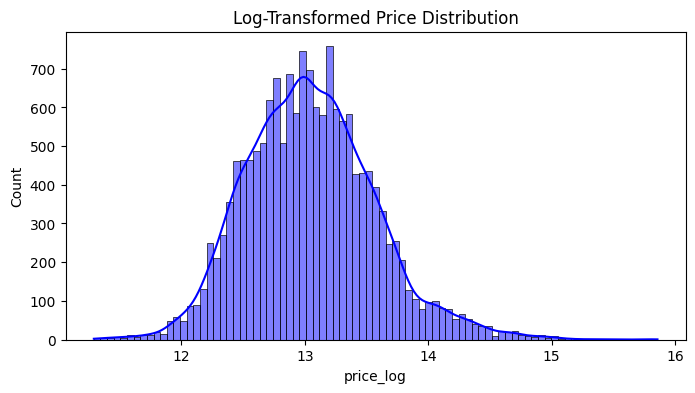

In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 0. SETUP DIRECTORIES
os.makedirs('data', exist_ok=True)

# 1. LOAD AND SYNC
image_folder = "house_images"
df = pd.read_excel("train(1).xlsx")

# Match IDs as strings to ensure perfect alignment with filenames
downloaded_ids = [str(f.split('.')[0]) for f in os.listdir(image_folder) if f.endswith('.jpg')]
df_clean = df[df['id'].astype(str).isin(downloaded_ids)].copy()
print(f"Synced Dataset Size: {len(df_clean)} rows")

# 2. CLEANING
df_clean = df_clean[df_clean['bedrooms'] < 30]
df_clean = df_clean[(df_clean['bedrooms'] > 0) & (df_clean['bathrooms'] > 0)]
df_clean = df_clean.drop_duplicates(subset='id')

# 3. FEATURE ENGINEERING
df_clean['price_log'] = np.log1p(df_clean['price'])
df_clean['house_age'] = 2025 - df_clean['yr_built']
df_clean['is_renovated'] = (df_clean['yr_renovated'] > 0).astype(int)
df_clean['sqft_lot_log'] = np.log1p(df_clean['sqft_lot'])

# Define numeric features (excluding 'date', 'id', and 'price')
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot_log', 'floors', 'waterfront', 
            'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 
            'sqft_lot15', 'lat', 'long', 'house_age', 'is_renovated']

# 4. SPLIT DATA (Before Scaling to avoid Data Leakage)
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42)

# 5. SCALING
scaler = StandardScaler()

# Fit ONLY on training data
train_features_scaled = scaler.fit_transform(train_df[features])
# Transform test data using training parameters
test_features_scaled = scaler.transform(test_df[features])

# 6. RECONSTRUCT DATASETS
def format_processed(df_original, scaled_array):
    new_df = pd.DataFrame(scaled_array, columns=features)
    new_df['id'] = df_original['id'].values
    new_df['price_log'] = df_original['price_log'].values
    return new_df

final_train = format_processed(train_df, train_features_scaled)
final_test = format_processed(test_df, test_features_scaled)

# 7. SAVE OUTPUTS
final_train.to_csv("data/processed_train.csv", index=False)
final_test.to_csv("data/processed_test.csv", index=False)
joblib.dump(scaler, 'data/scaler.pkl')

print("Preprocessing complete! Data and Scaler saved in /data folder.")

# 8. VISUAL CHECK
plt.figure(figsize=(8, 4))
sns.histplot(df_clean['price_log'], kde=True, color='blue')
plt.title("Log-Transformed Price Distribution")
plt.show()